In [4]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from nHits_trigger.src.read_data          import nHits, read_mpmt_offsets
from WCTE_BRB_Data_Analysis.wcte.brbtools import sort_run_files, get_part_files

from tqdm import tqdm

pltext.style()

In [5]:
datapath="/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/data/"
filename="run_1766_signal_N20candidates_unfiltered.csv"
data = pd.read_csv(datapath+filename)

In [6]:
data

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,76264.181597,79.0,27.0,2.0,9.0,3.0
1,0.0,76273.067467,209.0,118.0,55.0,3.0,18.0
2,1.0,209221.084343,103.0,114.0,19.0,13.0,12.0
3,1.0,209223.152791,119.0,114.0,19.0,12.0,4.0
4,1.0,209233.144440,175.0,114.0,19.0,10.0,10.0
...,...,...,...,...,...,...,...
2708303,383767.0,312021.117926,227.0,44.0,43.0,17.0,15.0
2708304,383767.0,312022.556373,69.0,36.0,46.0,10.0,10.0
2708305,383768.0,405073.289513,204.0,104.0,40.0,4.0,1.0
2708306,383768.0,405081.234585,142.0,89.0,89.0,18.0,16.0


In [7]:
data_by_event=data.groupby("event_id")

In [8]:
event=data_by_event.get_group(0)

In [9]:
np.sum(event.hit_pmt_charges.values)

np.float64(288.0)

In [10]:
#HISTOGRAMA DE HITS POR EVENTO, prueba1

#cada fila de datos es un hit=llega un fotón
#Evento: período de tiempo fijo en el que se recogen hits

In [11]:
#1º) Agrupo los hits en sus respectivos eventos

# Tenemos 2708308 hits en total, pero queremos agruparlos en el evento en el que llegaron: evento 0, 1,..., 383768 (event_id)

data_by_event=data.groupby("event_id") # .groupby("event_id") toma todas las filas con el mismo event_id y las junta en grupos

print(len(data_by_event)) #para ver cuántos grupos tengo uso len(); lo imprimo para verlo
#este es el nº de valores diferentes que tengo de event_id, que coincide con 0+383768=383769

383769


In [14]:
#2º) Cuento cuántos hits hay en cada grupo, cuántos fotones llegaron en cada evento
hits_by_event=data_by_event.size() #.size() devuelve el nº de filas en cada grupo, el nº de hits en cada grupo
print(hits_per_event)


#==============CHATTY===========================================
# Busco los 30 eventos con más hits
top_30_events=hits_by_event.nlargest(30) #crea una serie con los 30 valores más grandes de hits_per_event

print("="*60)
print("TOP 30 EVENTOS CON MÁS HITS")
print("="*60)

# Convertir a DataFrame con ranking desde 1
top_30_df = top_30_events.reset_index()
top_30_df.columns = ['event_id', 'hits']
top_30_df.index = top_30_df.index + 1
top_30_df.index.name = 'ranking'  # Nombre del índice

print(top_30_df)
#==============CHATTY===========================================

event_id
0.0          2
1.0          3
2.0          5
3.0          3
4.0          2
            ..
383764.0     2
383765.0     2
383766.0     3
383767.0    10
383768.0     3
Length: 383769, dtype: int64
TOP 30 EVENTOS CON MÁS HITS
         event_id  hits
ranking                
1            57.0   139
2           182.0   139
3           443.0   139
4           593.0   139
5           651.0   139
6           666.0   139
7           670.0   139
8           678.0   139
9           777.0   139
10          877.0   139
11         1093.0   139
12         1297.0   139
13         1717.0   139
14         1819.0   139
15         1912.0   139
16         2062.0   139
17         2119.0   139
18         2179.0   139
19         2250.0   139
20         2270.0   139
21         2310.0   139
22         2462.0   139
23         2592.0   139
24         2605.0   139
25         2649.0   139
26         2853.0   139
27         2933.0   139
28         3301.0   139
29         3344.0   139
30         3500.0   139


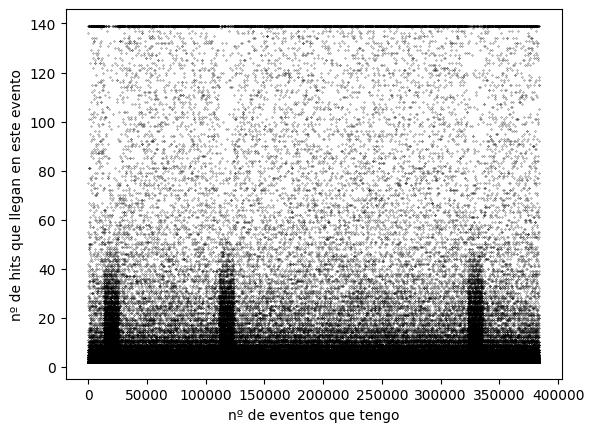

In [15]:
#3º) Puedo representar hits vs grupo para visualizar cuántos fotones llegaron en cada evento

#Eje x= índice del grupo, data_by_event (desde 0 hasta 383768)
#Eje y= númeor de hits dentro del grupo

plt.figure()
plt.scatter(hits_by_event.index, hits_by_event.values, s=0.05)
plt.xlabel("nº de eventos que tengo")
plt.ylabel("nº de hits que llegan en este evento") #aquí no sé por qué pasa esto, debería haber sólo un valor??? creo q está bn así
plt.show()

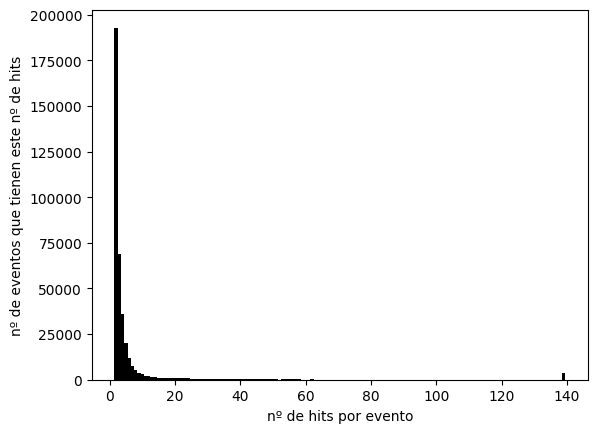

In [16]:
#4º) Ahora tengo que hacer el histograma

#usaremos: plt.hist(datos_que_queremos_graficar, bins=nº_de_barras)

hits=hits_by_event.values

#np.arange(hits.min(), hits.max()+2) crea un array que va desde el mínimo hasta el máx+2 de hits por evento (por grupo)
#se le resta 0.5 para centrar las barras del histograma en los valores enteros

bins=np.arange(hits.min(), hits.max()+2) - 0.5 

plt.figure()
plt.hist(hits, bins)
plt.xlabel("nº de hits por evento")
plt.ylabel("nº de eventos que tienen este nº de hits")
plt.show()